We are looking at the problem MAX $k$ XOR, where each variable is involved in $D+1$ clauses and has no overlapping constraints.

This is code comparing one-local algorithms: Hirvonen's threshold algorithm and Farhi's QAOA at depth 1.

In [1]:
from functools import lru_cache
from numpy import cos, sin, tan, arctan as atan
from scipy import stats
from scipy.integrate import quad
from scipy.optimize import minimize
from scipy.special import binom, erf
from sympy import exp, simplify, expand, expand_trig, trigsimp
import matplotlib.pyplot as plt
import numpy as np
import sympy
import time

In [2]:
print("Starting time:", time.ctime())

Starting time: Thu Aug 19 02:55:33 2021


# QAOA for MAX 3 XOR

In [3]:
def qaoa_perf_3xor(s, D):
    return s/ ( 1 + 3/(1 - s*s)**D)**0.5

In [4]:
gamma = sympy.Symbol('gamma')
D_symbol = sympy.Symbol('D')
qaoa_perf_3xor(sympy.sin(gamma), D_symbol)

(1 + 3*(1 - sin(gamma)**2)**(-D))**(-0.5)*sin(gamma)

In [5]:
Ds = [5, 10, 20, 50, 100, 500, 1000, 5000, 10000, 50000, 500000]
inps = np.linspace(0, 3, 100000)

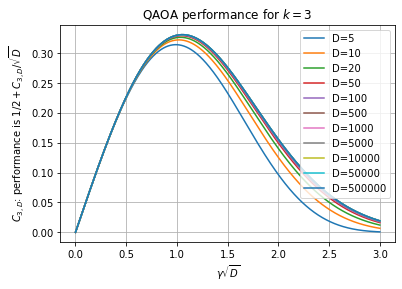

In [6]:
for D in Ds:
    outs = [qaoa_perf_3xor(np.sin(i*D**-0.5), D)*D**0.5 for i in inps]
    plt.plot(inps, outs, label="D=" + str(D))
plt.grid()
plt.legend()
plt.title("QAOA performance for $k=3$")
plt.xlabel("$\gamma \sqrt{D}$")
plt.ylabel("$C_{3,D}$: performance is $1/2 + C_{3,D}/\sqrt{D}$")
plt.savefig("images/QAOA_max3xor.png",  dpi=300)

We can also look at the derivative of performance with respect to $\gamma$:

In [7]:
qaoa_perf_derivative = sympy.lambdify((gamma, D_symbol), sympy.Derivative(qaoa_perf_3xor(sympy.sin(gamma), D_symbol), gamma, evaluate=True))

5 0.9889298892988929 -7.89382122379223e-06
10 1.019440194401944 -5.557421224877679e-07
20 1.035970359703597 9.036765468040109e-06
50 1.0463804638046381 -6.05624229221835e-06
100 1.049920499204992 -3.116431702476774e-06
500 1.052770527705277 7.448490694839105e-06
1000 1.053130531305313 7.55082733017165e-06
5000 1.053430534305343 -1.179938904916078e-07
10000 1.053460534605346 3.909266844126513e-06
50000 1.053490534905349 3.155058544646039e-06
500000 1.053490534905349 7.4604497740105025e-06


Text(0.5, 1.0, 'first derivative')

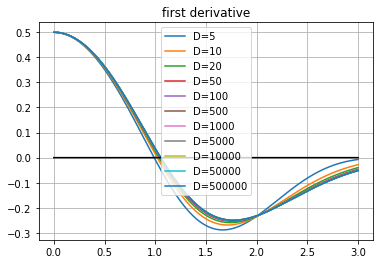

In [8]:
for D in Ds:
    outs = [qaoa_perf_derivative(i*D**-0.5, D) for i in inps]
    plt.plot(inps, outs, label="D=" + str(D))
    pt = np.argmin(np.abs(outs))
    print(D, inps[pt], outs[pt])
plt.grid()
plt.plot(inps, [0]*inps, color='black')
plt.legend()
plt.title("first derivative")

Let's check to make sure this works given $\gamma$ and $\beta$. Using the asymptotic values:

In [9]:
def qaoa_perf_2var_3xor(beta, gamma, D):
    p, q = np.cos(2*beta), np.sin(2*beta)
    c, s = np.cos(gamma), np.sin(gamma)
    return 0.5*q*s*(3*p*p*c**D - q*q*c**(3*D))

In [10]:
D = 100
gamma = 1.0535/D**0.5
beta = np.arcsin((1/(np.cos(gamma)**(2*D) + 3))**0.5)/2
print(beta, gamma)
print(qaoa_perf_2var_3xor(beta, gamma, D)*D**0.5)

0.29003649304891665 0.10535000000000001
0.3305431427004284


Text(0.5, 1.0, 'QAOA for MAX 3 XOR')

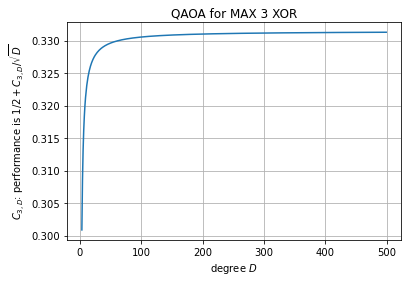

In [11]:
Ds = range(3, 500, 1)
plt.plot(Ds, [qaoa_perf_2var_3xor(0.29, 1.0535/D**0.5, D)*D**0.5 for D in Ds])
plt.grid()
plt.xlabel("degree $D$")
plt.ylabel("$C_{3,D}$: performance is $1/2 + C_{3,D}/\sqrt{D}$")
plt.title("QAOA for MAX 3 XOR")

Text(0.5, 1.0, 'QAOA for MAX 3 XOR')

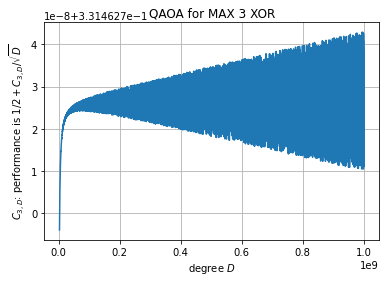

In [12]:
Ds = range(3000000, 1000000000, 100000)
plt.plot(Ds, [qaoa_perf_2var_3xor(0.29, 1.0535/D**0.5, D)*D**0.5 for D in Ds])
plt.grid()

plt.xlabel("degree $D$")
plt.ylabel("$C_{3,D}$: performance is $1/2 + C_{3,D}/\sqrt{D}$")
plt.title("QAOA for MAX 3 XOR")

What's the asymptotic value of QAOA on MAX 3 XOR?

In [13]:
def v(k):
    return k / (1 + 3*exp(k*k))**0.5

In [14]:
k = sympy.Symbol('k')
der = sympy.lambdify(k, sympy.Derivative(v(k), k, evaluate=True))

In [15]:
sympy.Derivative(v(k), k, evaluate=True)

-3.0*k**2*(3*exp(k**2) + 1)**(-1.5)*exp(k**2) + (3*exp(k**2) + 1)**(-0.5)

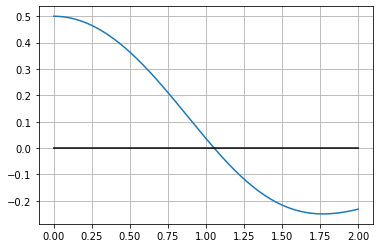

In [16]:
inps = np.linspace(0, 2, 10000000)
plt.plot(inps, der(inps))
plt.plot(inps, [0]*inps, color='black')
plt.grid()

In [17]:
pt = np.argmin(np.abs(der(inps)))
inps[pt], der(inps)[pt]

(1.0535025053502505, 3.2796303450766118e-09)

In [18]:
v(inps[pt])

0.331462726717571

What are the optimal values of QAOA for every degree?

In [19]:
fmaker = lambda D: lambda i: -qaoa_perf_3xor(np.sin(i*D**-0.5), D)*D**0.5

In [20]:
Ds = range(2, 10000)

In [21]:
optimized_vals = [-minimize(fmaker(D), 1).fun for D in Ds]

In [22]:
comparison = [qaoa_perf_2var_3xor(0.29, 1.0535/D**0.5, D)*D**0.5 for D in Ds]
assert np.all(np.array([o-c for o,c in zip(optimized_vals, comparison)]) > 0)

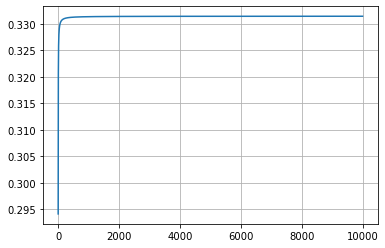

In [23]:
plt.plot(Ds, optimized_vals)
plt.grid()

# The threshold algorithm for MAX 3 XOR

In [24]:
@lru_cache(maxsize=int(1e7))
def g(D, t):
    return 2**(-D) * sum([binom(D,i) for i in range(0, t+1)])

In [25]:
@lru_cache(maxsize=int(1e7))
def Delta(D, t):
    return 2**(-D)* binom(D, t)

In [26]:
@lru_cache(maxsize=int(1e7))
def general_improvement(D, t, k):
    val_delta = Delta(D, t)
    val_g = g(D, t)
    return 0.25 * ( (1-2*val_g + 2*val_delta)**k - (1 - 2*val_g)**k )

What's the performance at $k=3$?

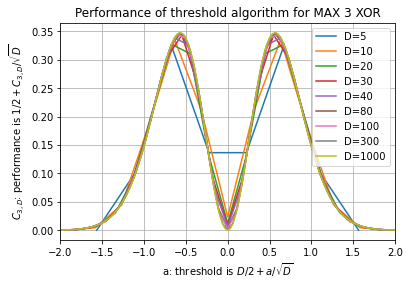

In [27]:
for D in [5, 10, 20, 30, 40, 80, 100, 300, 1000]:
    inps = np.array(list(range(-1, D+2)))
    plt.plot((inps/D - 1/2)*D**0.5, [general_improvement(D, t, 3)*D**0.5 for t in inps], label="D=" + str(D))

plt.legend()
plt.ylabel("$C_{3,D}$: performance is $1/2 + C_{3,D}/\sqrt{D}$")
plt.xlabel("a: threshold is $D/2 + a/\sqrt{D}$")
plt.xlim(-2, 2)
plt.title("Performance of threshold algorithm for MAX 3 XOR")
plt.grid()

Finding the optimal threshold:

In [28]:
def get_argmax(D, k, negative_only=False):
    if negative_only:
        inps = range(-1, int(D/2))
    else:
        inps = range(-1, D+2)
    return inps[np.argmax([general_improvement(D, t, k) for t in inps])]

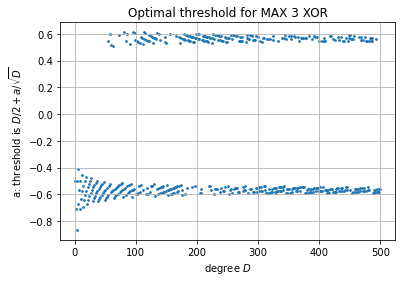

In [29]:
inps = range(1, 500)
plt.scatter(inps, [(get_argmax(D, 3) - D/2)/D**0.5 for D in inps], s=3)
plt.xlabel("degree $D$")
plt.ylabel("a: threshold is $D/2 + a/\sqrt{D}$")
plt.title("Optimal threshold for MAX 3 XOR")
plt.grid()

If we only look at thresholds below $D/2$, we get a clearer pattern:

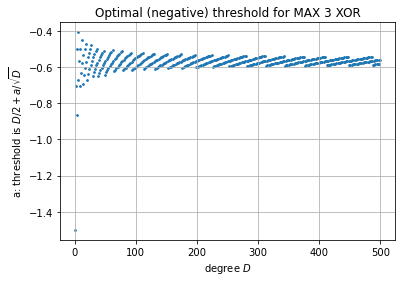

In [30]:
inps = range(1, 500)
plt.scatter(inps, [(get_argmax(D, 3, True) - D/2)/D**0.5 for D in inps], s=3)
plt.xlabel("degree $D$")
plt.ylabel("a: threshold is $D/2 + a/\sqrt{D}$")
plt.title("Optimal (negative) threshold for MAX 3 XOR")
plt.grid()

# Comparison for MAX 3 XOR

In [31]:
def get_max(D, k):
    inps = range(-1, D+2)
    return max([general_improvement(D, t, k) for t in inps])

Text(0, 0.5, '$C_{3,D}$: performance is $1/2 + C_{3,D}/\\sqrt{D}$')

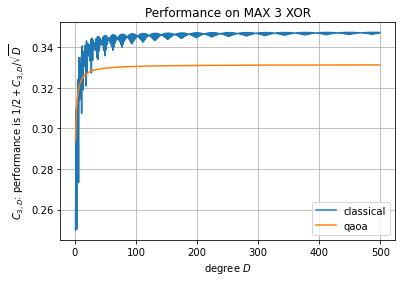

In [32]:
inps = range(1, 500)
plt.plot(inps, [get_max(D, 3)*D**0.5 for D in inps], label='classical')
plt.plot(inps, optimized_vals[:len(inps)], label='qaoa')
plt.legend()
plt.grid()
plt.title("Performance on MAX 3 XOR")
plt.xlabel("degree $D$")
plt.ylabel("$C_{3,D}$: performance is $1/2 + C_{3,D}/\sqrt{D}$")

Zooming in at small degree:

Text(0, 0.5, '$C_{3,D}$: performance is $1/2 + C_{3,D}/\\sqrt{D}$')

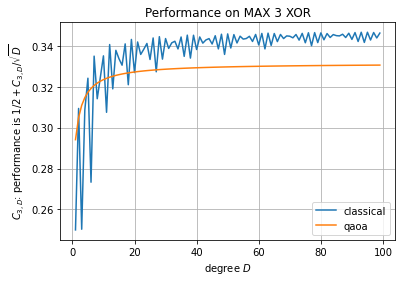

In [33]:
inps = range(1, 100)
plt.plot(inps, [get_max(D, 3)*D**0.5 for D in inps], label='classical')
plt.plot(inps, optimized_vals[:len(inps)], label='qaoa')
plt.legend()
plt.grid()
plt.title("Performance on MAX 3 XOR")
plt.xlabel("degree $D$")
plt.ylabel("$C_{3,D}$: performance is $1/2 + C_{3,D}/\sqrt{D}$")

When does QAOA win?

In [34]:
np.array(inps)[[get_max(D, 3)*D**0.5 - o < 0 for D, o in zip(inps, optimized_vals[:len(inps)])]]

array([ 1,  3,  4,  6,  8, 11, 13, 18, 20, 27])

# Threshold algorithm for MAX $k$ XOR

The performance increases with $k$.

Text(0, 0.5, '$C_{k,D}$: performance is $1/2 + C_{k,D}/\\sqrt{D}$')

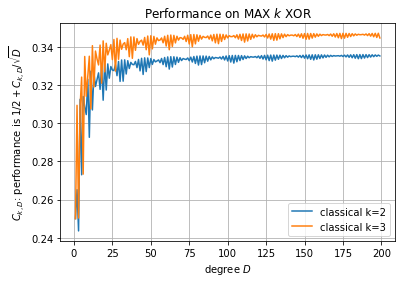

In [35]:
inps = range(1, 200)
for k in range(2, 4):
    plt.plot(inps, [get_max(D, k)*D**0.5 for D in inps],label="classical k=" + str(k))
plt.grid()
plt.legend()
plt.title("Performance on MAX $k$ XOR")
plt.xlabel("degree $D$")
plt.ylabel("$C_{k,D}$: performance is $1/2 + C_{k,D}/\sqrt{D}$")

Text(0, 0.5, '$C_{k,D}$: performance is $1/2 + C_{k,D}/\\sqrt{D}$')

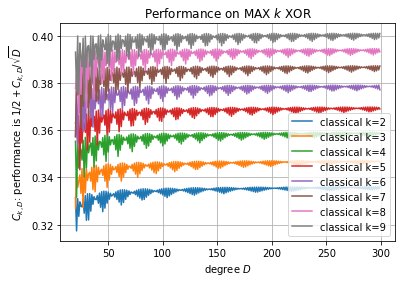

In [36]:
inps = range(20, 300)
for k in range(2, 10):
    plt.plot(inps, [get_max(D, k)*D**0.5 for D in inps],label="classical k=" + str(k))
plt.grid()
plt.legend()
plt.title("Performance on MAX $k$ XOR")
plt.xlabel("degree $D$")
plt.ylabel("$C_{k,D}$: performance is $1/2 + C_{k,D}/\sqrt{D}$")

Text(0, 0.5, '$C_{k,D}$: performance is $1/2 + C_{k,D}/\\sqrt{D}$')

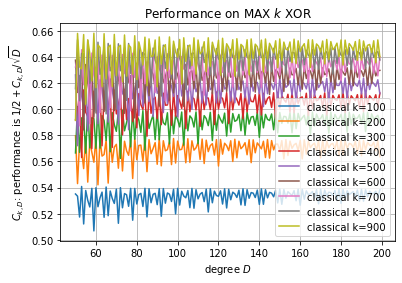

In [37]:
inps = range(50, 200)
for k in range(100, 1000, 100):
    plt.plot(inps, [get_max(D, k)*D**0.5 for D in inps],label="classical k=" + str(k))
plt.grid()
plt.legend()
plt.title("Performance on MAX $k$ XOR")
plt.xlabel("degree $D$")
plt.ylabel("$C_{k,D}$: performance is $1/2 + C_{k,D}/\sqrt{D}$")

What about the optimal threshold?

Text(0, 0.5, 'a: threshold is $D/2 + a/\\sqrt{D}$')

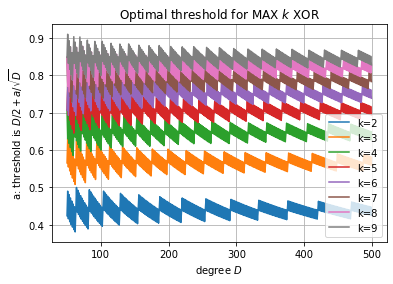

In [38]:
inps = range(50, 500)
for k in range(2,10):
    plt.plot(inps, [abs(get_argmax(D, k) - D/2)/D**0.5 for D in inps], label='k=' + str(k))
plt.grid()
plt.legend()
plt.title("Optimal threshold for MAX $k$ XOR")
plt.xlabel("degree $D$")
plt.ylabel("a: threshold is $D/2 + a/\sqrt{D}$")

### Large degree approximation

alpha (k=2): -0.4384483844838448
improvement*rtD: 0.33648925802613555
alpha (k=3): -0.5661056610566105
improvement*rtD: 0.34753464968074316
alpha (k=4): -0.6461164611646116
improvement*rtD: 0.35948123367974816
alpha (k=5): -0.7040770407704077
improvement*rtD: 0.37007481521513996
alpha (k=6): -0.7493114931149312
improvement*rtD: 0.37934716987803424


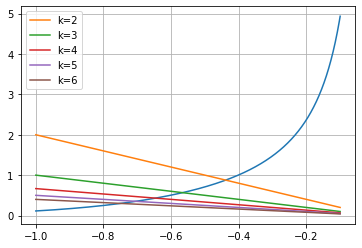

In [39]:
def f(alpha):
    return -erf(2**0.5 * alpha)

def grtD(alpha):
    return (2/np.pi)**0.5 * np.e**(-2*alpha*alpha)

def large_degree_improvement(alpha, k):
    return f(alpha)**k * (k/2) * (-2*alpha)/(k-1)

inps = np.linspace(-1, -0.1, 100000)
plt.plot(inps, [grtD(i)/f(i) for i in inps])
for k in range(2, 7):
    plt.plot(inps, -2*inps/(k-1), label='k=' + str(k))
    alpha = inps[[(grtD(i)/f(i)+2*i/(k-1) > 0) for i in inps]][0]
    print('alpha (k=' + str(k) + '):', alpha)
    print('improvement*rtD:', large_degree_improvement(alpha, k))
plt.legend()
plt.grid()

We can use SciPy to find the optimal threshold and value.

In [40]:
fmaker = lambda k: lambda i: abs(grtD(i)/f(i)+2*i/(k-1))

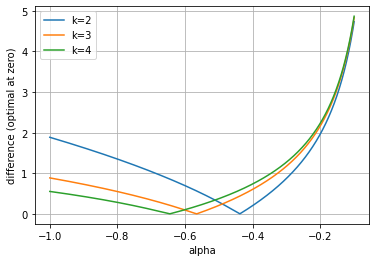

In [41]:
for k in [2,3,4]:
    plt.plot(inps, fmaker(k)(inps), label='k=' + str(k))
plt.xlabel("alpha")
plt.ylabel("difference (optimal at zero)")
plt.grid()
plt.legend()

In [42]:
ks = range(2, 200)
best_alphas = [minimize(fmaker(k), -1, method='Nelder-Mead', options={"ftol":1e-10}).x[0] for k in ks]
best_threshold_perf = [large_degree_improvement(a, k) for a,k in zip(best_alphas, ks)]

In [43]:
for i in range(18):
    print("k:", ks[i], "alpha:", best_alphas[i], "perf:", best_threshold_perf[i])

k: 2 alpha: -0.4384504927322263 perf: 0.33649336434608373
k: 3 alpha: -0.566110652685165 perf: 0.34754360662427763
k: 4 alpha: -0.646119719278067 perf: 0.35948708249696404
k: 5 alpha: -0.7040850546211003 perf: 0.37008946845499674
k: 6 alpha: -0.7493118736892935 perf: 0.37934788180340984
k: 7 alpha: -0.7862569719552992 perf: 0.3874867747324553
k: 8 alpha: -0.817399865761399 perf: 0.39471621046350674
k: 9 alpha: -0.8442601535469293 perf: 0.40120335548614106
k: 10 alpha: -0.8678350865840913 perf: 0.4070774997450675
k: 11 alpha: -0.8888135105371475 perf: 0.4124388540093239
k: 12 alpha: -0.9076905906200408 perf: 0.41736591797938943
k: 13 alpha: -0.924833858758211 perf: 0.4219210415038646
k: 14 alpha: -0.9405233614146706 perf: 0.4261543840769254
k: 15 alpha: -0.9549772322177886 perf: 0.43010682728185895
k: 16 alpha: -0.9683685787022114 perf: 0.43381207871486654
k: 17 alpha: -0.9808370001614093 perf: 0.4372982310985033
k: 18 alpha: -0.9924966532737016 perf: 0.4405889197979946
k: 19 alpha: -1.

Text(0.5, 1.0, 'Best asymptotic performance of threshold algorithm for MAX $k$ XOR')

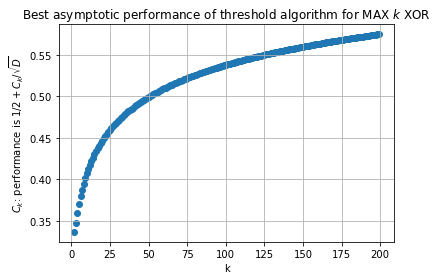

In [44]:
plt.scatter(ks, best_threshold_perf)
plt.grid()
plt.xlabel("k")
plt.ylabel("$C_{k}$: performance is $1/2 + C_{k}/\sqrt{D}$")
plt.title("Best asymptotic performance of threshold algorithm for MAX $k$ XOR")

Comparing the expression with its large-degree asymptotic form:

In [45]:
@lru_cache(maxsize=int(1e7))
def long_range_improvement(D, t, k):
    alpha = (t - D/2)*D**-0.5
    val_delta = (2/np.pi/D)**0.5 * np.e**(-2*alpha*alpha)
    val_g = 0.5 + 0.5*erf(2**0.5 * alpha) + 0.5 * val_delta
    return 0.25 * ( (1-2*val_g + 2*val_delta)**k - (1 - 2*val_g)**k )

Text(0.5, 1.0, 'asymptotic (large-degree) vs generic performance of threshold algorithm; D=1000')

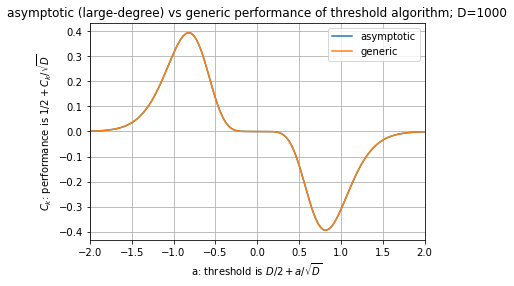

In [46]:
D = 1000
k = 8
inps = np.array(list(range(-1, D+2)))
plt.plot((inps/D - 1/2)*D**0.5, [long_range_improvement(D, t, k)*D**0.5 for t in inps], label='asymptotic')
plt.plot((inps/D - 1/2)*D**0.5, [general_improvement(D, t, k)*D**0.5 for t in inps], label='generic')
plt.xlim(-2, 2)
plt.grid()
plt.xlabel("a: threshold is $D/2 + a/\sqrt{D}$")
plt.ylabel("$C_{k}$: performance is $1/2 + C_{k}/\sqrt{D}$")
plt.legend()
plt.title("asymptotic (large-degree) vs generic performance of threshold algorithm; D="  +str(D))

# QAOA for MAX $k$ XOR

We have a relationship from $\gamma$ to $\beta$. So let's plot performance as a single-variable function:

In [47]:
# @lru_cache(maxsize=int(1e7))
def gamma_from_beta(b, k, D):
    return atan( ((tan(2*b)**(-2) + 1)/k/D)**0.5 )

In [48]:
def f(b, k, D):
    p, q = cos(2*b), sin(2*b)
    g = gamma_from_beta(b, k, D)
    c, s = cos(g), sin(g)
    return -0.25*s*1j*( (p + 1j*q*c**D)**k - (p - 1j*q*c**D)**k )

k: 3 D: 2 beta/pi: 0.09113411341134134 gamma: 0.6457133550969802 perf: 0.29410412861806556
k: 3 D: 5 beta/pi: 0.09178417841784199 gamma: 0.4422524799948612 perf: 0.3146569554910147
k: 3 D: 10 beta/pi: 0.09203420342034223 gamma: 0.3223806563933743 perf: 0.32268419004512405
k: 3 D: 20 beta/pi: 0.09215921592159236 gamma: 0.23167755729751552 perf: 0.32697175492210245
k: 3 D: 100 beta/pi: 0.09228422842284248 gamma: 0.10498972786802262 perf: 0.33054742740112547
k: 3 D: 500 beta/pi: 0.09230923092309251 gamma: 0.04707999959190555 perf: 0.33127896219847697
k: 3 D: 1000 beta/pi: 0.09230923092309251 gamma: 0.033302887938561315 perf: 0.33137080088961723
k: 3 D: 10000 beta/pi: 0.09230923092309251 gamma: 0.010534803199471842 perf: 0.3314535299965894
k: 4 D: 2 beta/pi: 0.07350735073507372 gamma: 0.6707077469306936 perf: 0.31273335595182417
k: 4 D: 5 beta/pi: 0.0744824482448247 gamma: 0.460203752247109 perf: 0.33641563218166026
k: 4 D: 10 beta/pi: 0.07485748574857508 gamma: 0.33568475060518954 perf: 0

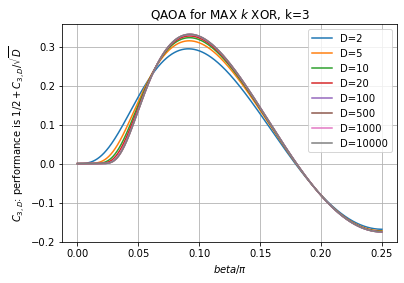

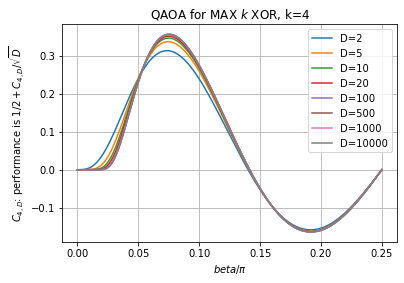

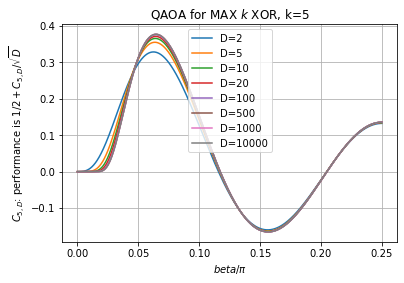

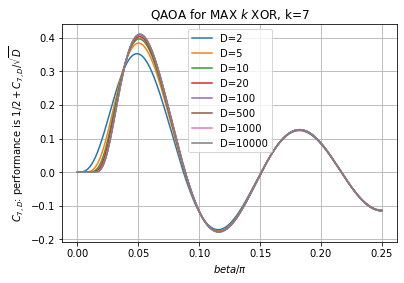

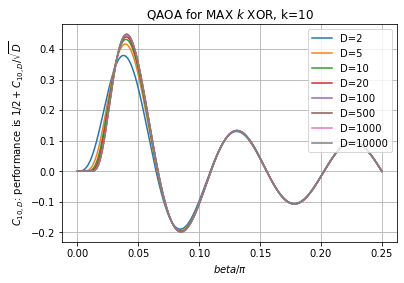

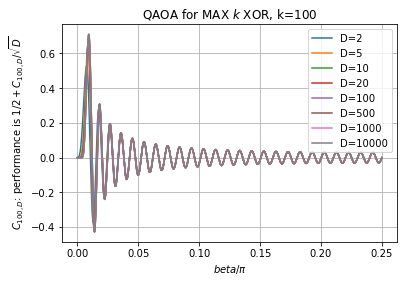

In [49]:
for k in [3, 4, 5, 7, 10, 100]:
    plt.figure()
    Ds = [2, 5, 10, 20, 100, 500, 1000, 10000]
    for D in Ds:
        inps = np.linspace(1e-15, np.pi/4, 10000)
        outs = [complex(f(i, k, D)).real*D**0.5 for i in inps]
        plt.plot(inps/np.pi, outs, label="D=" + str(D))
        print('k:', k, "D:", D, 'beta/pi:', inps[np.argmax(outs)]/np.pi, 'gamma:', gamma_from_beta(inps[np.argmax(outs)], k, D), 'perf:', np.max(outs))
    plt.title("QAOA for MAX $k$ XOR, k=" + str(k))
    plt.grid()
    plt.ylabel("$C_{" + str(k) + ",D}$: performance is $1/2 + C_{" + str(k) + ",D}/\sqrt{D}$")
    plt.xlabel("$ beta / \pi$")
    plt.legend()

Find the maximum performance of QAOA for any k and D:

In [50]:
fmaker = lambda k, D: lambda i: -complex(f(i, k, D)).real*D**0.5

In [51]:
def get_qaoa_max(k,D):
    # do pass to find approximate optimum
    inps = np.linspace(1e-15, np.pi/4, 100)
    outs = [complex(f(i, k, D)).real*D**0.5 for i in inps]
    return -minimize(fmaker(k, D), inps[np.argmax(outs)]).fun

CPU times: user 6.26 s, sys: 11.9 ms, total: 6.27 s
Wall time: 6.27 s


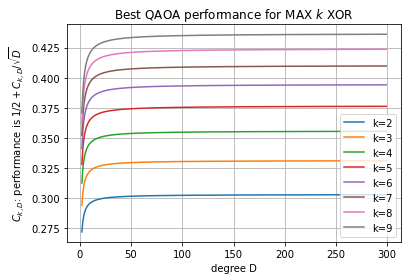

In [52]:
%%time
for k in range(2, 10):
    Ds = range(2, 300)
    qaoa_kxor = [get_qaoa_max(k,D) for D in Ds]
    plt.plot(Ds, qaoa_kxor, label="k=" + str(k))
plt.grid()
plt.xlabel('degree D')
plt.legend()
plt.ylabel("$C_{k,D}$: performance is $1/2 + C_{k,D}/\sqrt{D}$")
plt.title("Best QAOA performance for MAX $k$ XOR")
plt.savefig('images/qaoa_best_maxkxor.png',  dpi=300)

### Limiting behavior for QAOA on MAX $k$ XOR

In [53]:
def qaoa_asymptotic_kxor(k,t):
    if t*t*k < 1:
        return 0
    term_1 = (t*t*k - 1)**0.5 + 1j*np.e**(-t*t/2)
    term_2 = (t*t*k - 1)**0.5 - 1j*np.e**(-t*t/2)
    return -0.25*1j * t**(1-k) * k**(-k/2) * (term_1**k - term_2**k)

k= 2 Max: 0.30326532976533727 at t= 1.000010000100001 beta= 0.3926940817237238
k= 3 Max: 0.33146272666069077 at t= 1.053510535105351 beta= 0.2900007252938392
k= 4 Max: 0.3559421057897224 at t= 1.097790977909779 beta= 0.2364444875259528
k= 5 Max: 0.3767105761875506 at t= 1.134771347713477 beta= 0.20254429534400661
k= 6 Max: 0.3945945274726129 at t= 1.1663716637166373 beta= 0.1787938843543141
k= 7 Max: 0.41025178270098717 at t= 1.1939319393193932 beta= 0.16105629649069836
k= 8 Max: 0.42415677803753304 at t= 1.2183321833218332 beta= 0.14721507819709934
k= 9 Max: 0.436652898412887 at t= 1.2402124021240213 beta= 0.1360585132329121
k= 10 Max: 0.4479939244835788 at t= 1.2600526005260053 beta= 0.12683796844261103
k= 11 Max: 0.45837176828801823 at t= 1.2781727817278172 beta= 0.1190684308018922
k= 12 Max: 0.46793469585178904 at t= 1.2948529485294853 beta= 0.1124149146297139
k= 13 Max: 0.4767994633283053 at t= 1.3103131031310313 beta= 0.10664016752303325
k= 14 Max: 0.48505957497866997 at t= 1.324

Text(0, 0.5, '$C_{k}$: performance is $1/2 + C_{k}/\\sqrt{D}$')

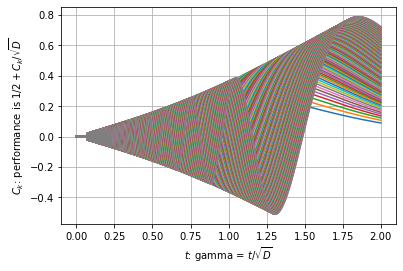

In [54]:
qaoa_asymptotic_maxes = []
for k in range(2, 200):
    inps = np.linspace(0, 2, 100000)
    outs = [qaoa_asymptotic_kxor(k,i).real for i in inps]
    plt.plot(inps, outs, label="k=" + str(k))
    if k < 20 or k % 5 == 0:
        t = inps[np.nanargmax(outs)]
        print("k=", str(k), "Max:", np.nanmax(outs), "at t=", t, 'beta=', np.arcsin(1/t/k**0.5)/2)
    qaoa_asymptotic_maxes.append(np.nanmax(outs))
plt.grid()
plt.xlabel("$t$: gamma = $t/\sqrt{D}$")
plt.ylabel("$C_{k}$: performance is $1/2 + C_{k}/\sqrt{D}$")
# plt.legend()

# Comparison for MAX $k$ XOR

CPU times: user 6.91 s, sys: 68 ms, total: 6.98 s
Wall time: 6.97 s


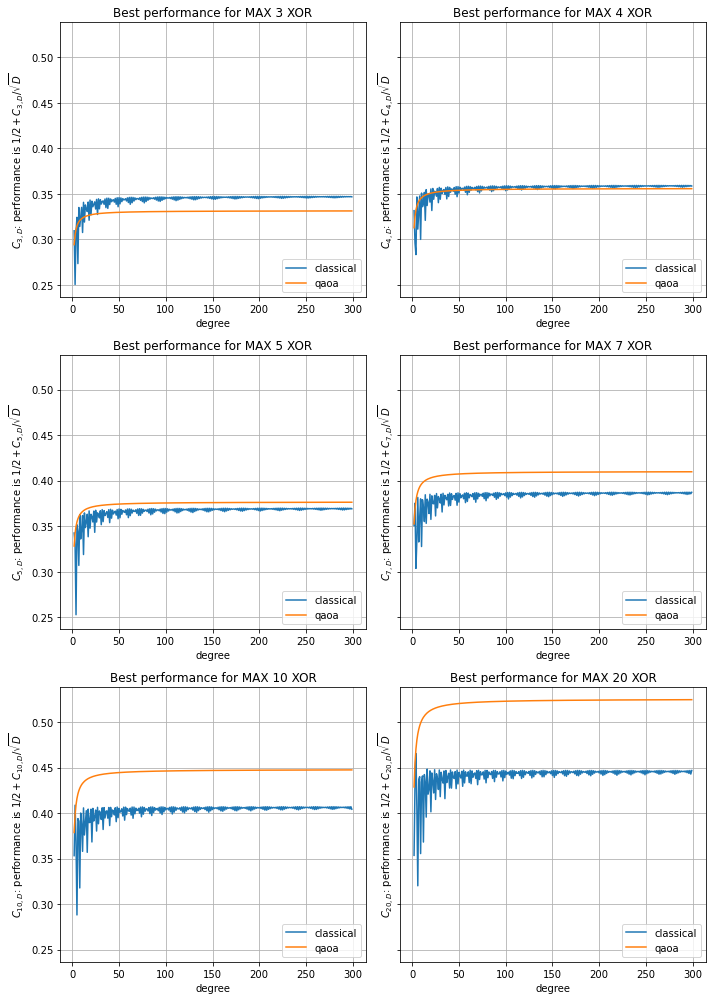

In [55]:
%%time
fig, axs = plt.subplots(3, 2, sharey=True, figsize=(10, 14))
axs = axs.reshape(-1,)
ks = [3, 4, 5, 7, 10, 20]
for i in range(len(ks)):
    ax = axs[i]
    k = ks[i]
    Ds = range(2,300)
    ax.plot(Ds, [get_max(D, k)*D**0.5 for D in Ds], label='classical')
    ax.plot(Ds, [get_qaoa_max(k,D) for D in Ds], label='qaoa')
    ax.grid()
    ax.set_xlabel('degree')
    ax.legend(loc='lower right')
    ax.set_ylabel("$C_{" + str(k) + ",D}$: performance is $1/2 + C_{" + str(k) + ",D}/\sqrt{D}$")
    ax.set_title("Best performance for MAX " + str(k) + " XOR")
fig.tight_layout()
plt.savefig('images/comparison.png',  dpi=300)

So for $k > 4$, the QAOA does better than the threshold algorithm.

This is true even in the large-degree limit.

In [56]:
max([q for q in qaoa_asymptotic_maxes if q != np.inf])

0.7882407077057314

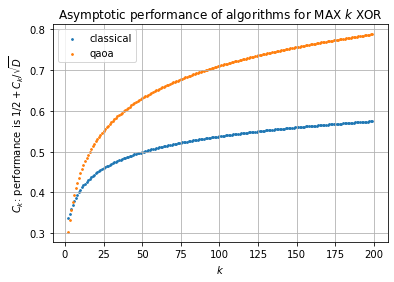

In [57]:
ks = range(2, 200)
plt.scatter(ks[:len(best_threshold_perf)], best_threshold_perf, label='classical', s=3)
plt.scatter(ks[:len(qaoa_asymptotic_maxes)], qaoa_asymptotic_maxes, label='qaoa', s=3)
plt.grid()
plt.xlabel("$k$")
plt.ylabel("$C_{k}$: performance is $1/2 + C_{k}/\sqrt{D}$")
plt.legend()
plt.title("Asymptotic performance of algorithms for MAX $k$ XOR")
plt.savefig('images/asymptotic_comparison.png',  dpi=300)

In [58]:
def logfit(x, y, deg=1):
    logx = np.log(x)
    logy = np.log(y)
    return np.polyfit(logx,logy,deg=deg)

# poly = np.poly1d(coeffs)
# yfit = lambda x: np.exp(poly(np.log(x)))
# plt.loglog(inps, yfit(inps))
# plt.loglog(inps, dataset)

In [59]:
dataset = qaoa_asymptotic_maxes
inps = ks[:len(dataset)]

qaoa_coeffs = logfit(inps, dataset, deg=1)
print(qaoa_coeffs)

dataset = best_threshold_perf
inps = ks[:len(dataset)]

threshold_coeffs = logfit(inps, dataset, deg=1)
print(threshold_coeffs)

[ 0.1917382  -1.23055679]
[ 0.11544326 -1.15496742]


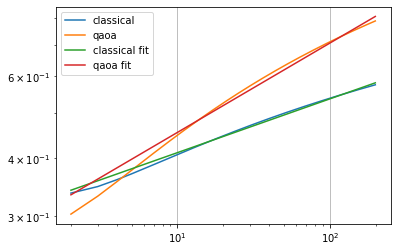

In [60]:
plt.loglog(ks, best_threshold_perf, label='classical')
plt.loglog(ks[:len(qaoa_asymptotic_maxes)], qaoa_asymptotic_maxes, label='qaoa')
plt.loglog(ks, [(np.e**threshold_coeffs[1])*k**threshold_coeffs[0] for k in ks], label='classical fit')
plt.loglog(ks, [(np.e**qaoa_coeffs[1])*k**qaoa_coeffs[0] for k in ks], label='qaoa fit')
plt.legend()
plt.grid()

This suggests that QAOA's performance scales as $k^{0.2}$ and the threshold algorithm's performance scales as $k^{0.1}$.

# Evaluating the Parisi formula for a pure p-spin glass

The goal here is to calculate the zero-temperature Parisi constant, and compare it to the maximum satisfying fraction of random XORSAT instances.

## Using the Parisi formula

Wei-Kuo Chen says:
> I am not aware of numerical simulations for the Parisi constant P(K) for large K. Nevertheless, this constant can be written as the Parisi formula, which is a convex optimization problem (see Theorem 1 in https://arxiv.org/pdf/1606.05335.pdf). With this, it should be fairly easy to run a numerical simulation to approximate P(K) for large K.


Paraphrased from the linked paper:
> We introduce the space $U$ that collects all nonnegative and nondecreasing functions $f$ on $[0,1)$ that are right continuous and satisfy $\int_0^1 f(t)dt < \infty$. Let's say $f$ has $k$ jumps. Then it has value $m_i$ in region $[q_i,q_{i+1})$, given $q_0 = 0$ and $q_{k+1} = 1$, where $m_i$ and $q_i$ are increasing and nonnegative. The distance metric $d$ is the integral of $f$, or equivalently, $d = \sum_{i=0}^k m_i(q_{i+1} - q_i)$.

$P(f) = \Psi_f(0, h) - 0.5 \int_0^1 t \xi^{''}(t)f(t) dt$

$\xi(s) =\sum_{p\ge 2} c_p^2 s^p$ Where the $c_p$'s are the mixing constants (mixed vs pure spin glasses).

$\partial_t \Psi_f(t,x) = -0.5\xi^{''}(t) 
\Big(
\partial_x^2 \Psi_f(t,x) + f(t) (\partial_x \Psi_f(t,x))^2
\Big)$

With boundary condition: $\Psi_f(1,x) = |x|$.

This can be solved recursively, by using the transformation $f(t) \Psi = \log \Phi$ for a piecewise, continuous function $f$.

This is the coefficient $a_{\ell} = \sqrt{ \xi^{'}(q_{\ell+1}) - \xi^{'}(q_{l}) }$

In [61]:
global k, xi, xiprime, xiprimeprime

In [62]:
def a(qs, l):
    return (xiprime(qs[l+1]) - xiprime(qs[l]))**0.5

Let $\Psi_{k+1}(x) = abs(x)$.

For $1\le \ell \le k$, let $Exp(m_{\ell} \Psi_{\ell}(x)) = \mathbb{E}[Exp(m_{\ell} \Psi_{\ell+1}(x + a_{\ell} z) ]$, for standard Gaussian variable $z$.

Let $\Psi_0(x) = \mathbb{E}[\Psi_{\ell+1}(x + a_{0} z)]$, since I let $m_0 = 0$.

In [63]:
def psi(qs, ms, l):
    offset = lambda x, z: psi(qs, ms, l+1)(x + a(qs, l)*z)
    if l == k+1:
        return lambda x: abs(x)
    elif l == 0:
        return Expectation(offset)
    else:
        return lambda v: 1/ms[l] * np.log(
            Expectation(lambda x, z: np.e**(ms[l]*offset(x,z)))(v)
        )

This defines the expectation value.

In [64]:
INPS = np.linspace(-20,20, 40001)
PDF_INPS = stats.norm.pdf(INPS)/1000
assert np.allclose(sum(PDF_INPS),1), sum(PDF_INPS)

In [65]:
def Expectation(f):
    # f is function of x and z, where z is gaussian
    return lambda x: np.sum(f(x,INPS)*PDF_INPS)

The penalty term in the operator is $0.5 \int_0^1 f(t)  t \xi^{''}(t) dt = 0.5 \sum_{i=0}^k \int_{q_i}^{q_{i+1}} m_i t \xi^{''}(t) dt$

In [66]:
def penalty(qs, ms):
    out = 0
    for i in range(k+1):
        integral = quad(lambda t: t * xiprimeprime(t), qs[i], qs[i+1])[0]
        out += ms[i] * integral
    return 0.5 * out

This tests the ground state energy of inputs **m**, **q**:

In [67]:
# the input here is a list of "adjustments" 
# (m_1, m_2-m_1, ...,m_k-m_{k-1}, q_1, q_2-q_1,...,q_k-q_{k-1})
def test(inp):
    assert len(inp) == 2*k
    inp_qs,inp_ms= inp[:k],inp[k:]

    # if bad input, return a large number
    if np.any(np.array(inp) < 0) or sum(inp_ms) > 1 or sum(inp_qs) > 1:
        return 10000

    qs = np.array([0,*[sum(inp_qs[:i+1]) for i in range(k)],1])
    ms = np.array([0,*[sum(inp_ms[:i+1]) for i in range(k)]])
    return psi(qs, ms, 0)(0) - penalty(qs, ms)

## Evaluating the Parisi formula

p: 2 1.8832514113627603
p: 3 1.992745524843181
p: 4 2.021981615495776
p: 5 2.03216852351392
p: 6 2.0362008561657907
p: 7 2.037915913208063
p: 8 2.038677953017544
p: 9 2.0390260819660497
p: 10 2.0391880458926916
p: 11 2.0392643310453185
p: 12 2.039300570243638
p: 13 2.0393178919308497
p: 14 2.0393262094756732
p: 15 2.0393302176125374
p: 16 2.0393321545959395
p: 17 2.039333092871928
p: 18 2.039333548280432
p: 19 2.039333769702445
p: 20 2.0393338775223278
p: 21 2.039333930095328
p: 22 2.039333955761016
p: 23 2.0393339683045255
p: 24 2.0393339744409786
p: 25 2.039333977445782
p: 26 2.039333978918357
p: 27 2.039333979640574
p: 28 2.039333979995032
p: 29 2.039333980169136
p: 30 2.0393339802546677
p: 31 2.0393339802967176
p: 32 2.0393339803174086
p: 33 2.039333980327605
p: 34 2.039333980332607
CPU times: user 1min 23s, sys: 15.7 ms, total: 1min 23s
Wall time: 1min 23s


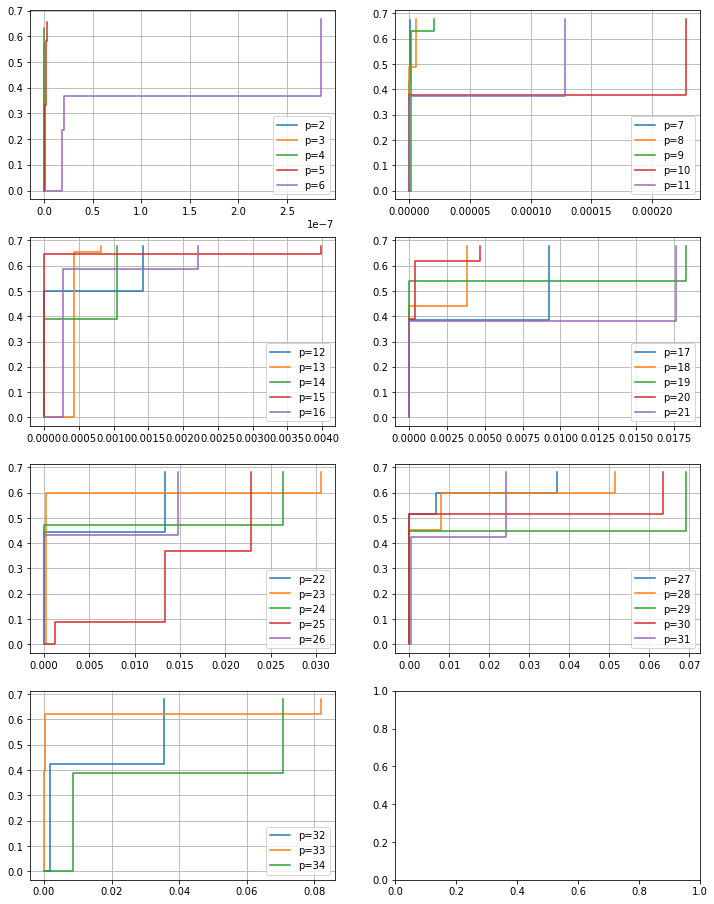

In [68]:
%%time

# pure p-spin model; p=2 is SK model
ps = range(2, 35)
# number of jumps
k=3
# if C_psq is too low, my convergence is not very good.
C_psq = 3

num_vert_plots = int(np.ceil(len(ps)/10))
fig, axs = plt.subplots(num_vert_plots, 2, figsize=(12, 4*num_vert_plots))
outs = []
for idx in range(len(ps)):
    P = ps[idx]
    if idx % 5 == 0:
        ax = axs[idx // 10, (idx % 10)//5]
        ax.grid()
    # should xi be different by 1/2 ? I've seen it both ways.
    xi = lambda x: x**P * C_psq
    xiprime = lambda x: P * (x**(P-1)) * C_psq
    xiprimeprime = lambda x: P * (P-1) * (x**(P-2)) * C_psq
    
    # find best function from minimizer
    best = None
    for _ in range(4):
        opt = minimize(test, 
                       [np.random.random()/k for _ in range(2*k)], 
                       method='Powell', 
                       options={"xtol": 1e-10, "ftol":1e-14}
                      )
        if not best or best.fun > opt.fun:
            best = opt
    print("p:", P, best.fun)
    outs.append(best.fun)

    qs = np.array([0,*[sum(best.x[:k][:i+1]) for i in range(k)]])
    ms = np.array([0,*[sum(best.x[k:][:i+1]) for i in range(k)]])
#     print("qs:", qs)
#     print("ms:", ms)
    ax.step(qs, ms, where='post', label="p=" + str(P))
    if idx % 5 == 4:
        ax.legend()

ax.legend()
outs = np.array(outs)

I notice that the locations of the symmetry breaking points are often at very low values.  This may be related to the Auffinger Chen Zeng result that perturbing a solution to this variational near $1$ will reduce the energy. So perhaps perturbations very close to $0$ can also reduce the energy: https://doi.org/10.1002/cpa.21886

## Finding the large-p limit

Let's look at the constants after dividing out by $c_p$:

In [69]:
outs_scaled = np.array(outs)* C_psq**-0.5

In [70]:
for p, x in zip(ps, outs_scaled):
    print(p, x)

2 1.0872957093020323
3 1.1505121651946324
4 1.1673916300029605
5 1.173273044089446
6 1.1756011124314656
7 1.176591301076497
8 1.177031264965634
9 1.1772322573077667
10 1.1773257672244124
11 1.1773698104778167
12 1.1773907331887217
13 1.177400733869496
14 1.177405536006239
15 1.1774078501051366
16 1.1774089684230251
17 1.1774095101369197
18 1.1774097730671418
19 1.1774099009052008
20 1.1774099631550392
21 1.177409993508075
22 1.177410008326167
23 1.1774100155681655
24 1.1774100191110484
25 1.1774100208458724
26 1.177410021696064
27 1.1774100221130361
28 1.1774100223176824
29 1.1774100224182016
30 1.1774100224675832
31 1.1774100224918609
32 1.1774100225038069
33 1.1774100225096935
34 1.1774100225125816


In [71]:
guess = (2*np.log(2))**0.5

In [72]:
print(guess)

1.1774100225154747


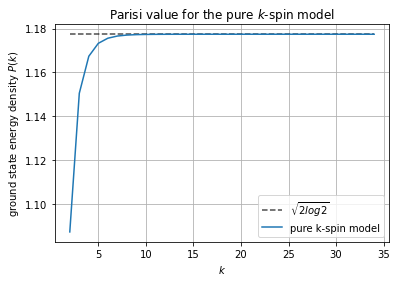

In [73]:
plt.plot(ps, [guess]*len(ps), 'b--', 
         color='black', label="$\sqrt{2 log 2}$", alpha=0.7)
plt.plot(ps, outs_scaled, label="pure k-spin model")
plt.xlabel("$k$")
plt.ylabel("ground state energy density $P(k)$")
plt.title("Parisi value for the pure $k$-spin model")
plt.grid()
plt.legend()
plt.savefig('images/parisi_value.png', dpi=300)

## Relationship with $c_{p}$

I ran the above several times for different $c_p$. 
The asymptotic value seems to depend on the constant I use. If $c_p^2 < 2 log(2)$, The energy is $log(2) + c_p^2 / 2$. Otherwise, the energy is $\sqrt{ 2 c_p^2 log(2)}$.

Text(0, 0.5, '$energy / C_p$')

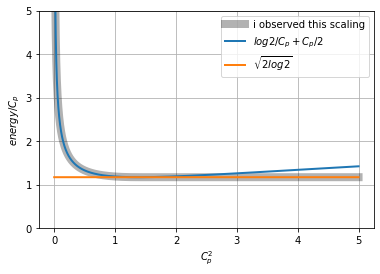

In [74]:
# this is what I observed after running for many different c_p^2
inps = np.linspace(1e-10, 5, 100000)
f1 = lambda x: x**-0.5 * (np.log(2) + x/2)
f2 = lambda x: x**-0.5 * (2 * x * np.log(2))**0.5

plt.plot(inps, [f1(i) if i < 2*np.log(2) else f2(i) for i in inps], 
         label='i observed this scaling',
         linewidth=8, alpha=0.3, color='black')
plt.plot(inps, f1(inps), label='$log 2/C_p +C_p/2$', linewidth=2)
plt.plot(inps, f2(inps), label='$\sqrt{2 log 2}$', linewidth=2)
# plt.plot(inps, inps**0.5, label='sqrt(x) (expected scaling)', linewidth=2)
plt.legend()
plt.grid()
plt.ylim(0,5)
plt.xlabel('$C_p^2$')
plt.ylabel("$energy / C_p$")

The minimum energy should be proportional to $c_p$. I think this means the limit of $P(p)$ is in fact $\sqrt{2 log 2}$.

This ended up being true, because of the relationship to the random energy model.

## Comparison with Montanari for 2,3-XORSAT

This also roughly matches the calculation in https://arxiv.org/pdf/2009.11481.pdf that does MAX 2 XOR and MAX 3 XOR. They get
$$
e_2 = 0.763168\pm 0.000002
$$
and 
$$
e_3 = 0.8132\pm 0.0001
$$

Where $e_2$ uses $\xi(s) = s^2/2$ and $e_3$ uses $\xi(s) = s^3/2$.

In [75]:
for p, o in list(zip(ps, outs_scaled))[:2]:
    print("my result, p:", p, "e_p:", o * 2**-0.5)

my result, p: 2 e_p: 0.7688341692025042
my result, p: 3 e_p: 0.813534953846742


The agreement gives me confidence that my approach is correct.

One way to improve my precision is to explicitly solve for the derivative, and use it in the optimization procedure (as the Montanari paper does).

## Using the Parisi constants in Sen's XORSAT upper bound

I insert these values for Subhabrata Sen's bounds for MAX XOR on hypergraphs, as listed here: https://doi.org/10.1002/rsa.20774

The satisfying fraction for MAX CUT on p-uniform hypergraphs is to first order in D: $\frac{1}{2}+ \frac{P_p \sqrt{p}}{2}\frac{1}{\sqrt{D}}$

This makes the satisfying fraction $\frac{1}{2} + \frac{C_p}{\sqrt{D}}$, where $C_p$ is listed below:

In [76]:
for p, x in zip(ps, outs_scaled):
    print(p, x * p**0.5 / 2)

2 0.7688341692025042
3 0.9963727624215902
4 1.1673916300029605
5 1.3117591413760548
6 1.4398114332526841
7 1.5564839887051674
8 1.6645735782515598
9 1.76584838596165
10 1.8615154862171785
11 1.9524469504233828
12 2.039300570243638
13 2.122589358867699
14 2.202724060513138
15 2.2800404975755364
16 2.3548179368460502
17 2.4272918874506337
18 2.49766330431327
19 2.5661053865850048
20 2.6327687150001906
21 2.697785209624109
22 2.7612712294134445
23 2.823330034262964
24 2.8840537648626583
25 2.943525052114681
26 3.0018183380639667
27 3.059000969460861
28 3.115134110207597
29 3.1702735081469733
30 3.224470143690799
31 3.2777707818345387
32 3.3302184445977896
33 3.3818528174843423
34 3.432710600889793


Because of the limit, we expect a large $p$ XORSAT problem to have satisfying fraction at most

$$\frac{1}{2} + \frac{\sqrt{2 log 2}}{2} \sqrt{\frac{p}{D}} = \frac{1}{2} + \sqrt{\frac{p log 2}{2}} \frac{1}{\sqrt{D}} \approx \frac{1}{2} + 0.58871\sqrt{\frac{p}{D}}$$

# Comparison with the Parisi constant (upper bound at large degree)

In [77]:
parisi_clean_data = np.array([[p, x * p**0.5 / 2] for p,x in zip(ps, outs_scaled)])

In [78]:
parisi_estimate = lambda x: (x*np.log(2)/2)**0.5

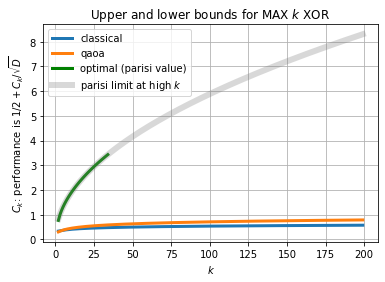

In [79]:
size = len(parisi_clean_data)
ks = np.array(list(range(2, 200)))
assert np.allclose(ks[:size], parisi_clean_data[:, 0])

plt.plot(ks[:len(best_threshold_perf)], best_threshold_perf, label='classical', linewidth=3)
plt.plot(ks[:len(qaoa_asymptotic_maxes)], qaoa_asymptotic_maxes, label='qaoa', linewidth=3)
plt.plot(parisi_clean_data[:, 0], parisi_clean_data[:,1], label='optimal (parisi value)', color='green', linewidth=3)
plt.plot(ks, parisi_estimate(ks), label='parisi limit at high $k$', color='gray', alpha=0.3, linewidth=6)

plt.grid()
plt.xlabel("$k$")
plt.ylabel("$C_{k}$: performance is $1/2 + C_{k}/\sqrt{D}$")
plt.legend()
plt.title("Upper and lower bounds for MAX $k$ XOR")
plt.savefig('images/parisi_comparison.png',  dpi=300)

## Bonus: Evaluating the $p$-SAT approximations

A similar formula to Sen has been done by Panchenko for $p$-SAT: https://arxiv.org/pdf/1608.06256.pdf

Given $N$ variables and $\alpha N$ clauses, the satisfying fraction is 
$$1-\frac{1}{2^p} + \frac{B_p}{2^p}\frac{1}{\sqrt{\alpha}}$$

Where $B_p$ is the limit of a Parisi formula with $\xi(x) = (1+x)^p - 1$.

p: 3 2.226114627466429
p: 4 3.756667039321632
p: 5 5.848339537971128
p: 6 8.734931651913222


<ipython-input-63-15554b3564ae>:9: RuntimeWarning: overflow encountered in power
  Expectation(lambda x, z: np.e**(ms[l]*offset(x,z)))(v)


p: 7 12.748894312355315


<ipython-input-63-15554b3564ae>:9: RuntimeWarning: overflow encountered in power
  Expectation(lambda x, z: np.e**(ms[l]*offset(x,z)))(v)


p: 8 18.362682768475057


<ipython-input-63-15554b3564ae>:9: RuntimeWarning: overflow encountered in power
  Expectation(lambda x, z: np.e**(ms[l]*offset(x,z)))(v)


p: 9 20.017177758190655
CPU times: user 1min 52s, sys: 55.2 ms, total: 1min 52s
Wall time: 1min 52s


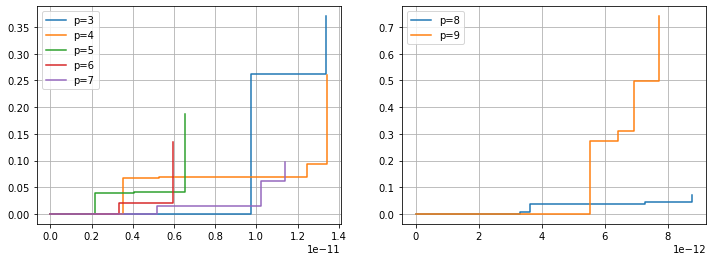

In [80]:
%%time

ps = range(3, 10)
# number of jumps
k=4

# CONST_SQ may affect my convergence.
CONST_SQ = 1

num_vert_plots = int(np.ceil(len(ps)/10))
fig, axs = plt.subplots(num_vert_plots, 2, figsize=(12, 4*num_vert_plots))
outs = []
for idx in range(len(ps)):
    P = ps[idx]
    if idx % 5 == 0:
        ax = axs[(idx % 10) //5] #axs[idx // 10, (idx % 10)//5]
        ax.grid()
    # should xi be different by 1/2 ? I've seen it both ways.
    xi = lambda x: CONST_SQ* (-1 + (1+x)**P)
    xiprime = lambda x: CONST_SQ* P * ((1+x)**(P-1))
    xiprimeprime = lambda x:CONST_SQ* P * (P-1) * ((1+x)**(P-2))
    
    # find best function from minimizer
    best = None
    for _ in range(10):
        opt = minimize(test, 
                       [np.random.random()/k for _ in range(2*k)],
                       method='Powell', 
                       options={"ftol":1e-14}
                      )
        if not best or best.fun > opt.fun:
            best = opt
    print("p:", P, best.fun)
    outs.append(best.fun)

    qs = np.array([0,*[sum(best.x[:k][:i+1]) for i in range(k)]])
    ms = np.array([0,*[sum(best.x[k:][:i+1]) for i in range(k)]])
#     print("qs:", qs)
#     print("ms:", ms)
    ax.step(qs, ms, where='post', label="p=" + str(P))
    if idx % 5 == 4:
        ax.legend()

ax.legend()
outs = np.array(outs)

The constants after reducing by CONST_SQ (to help with convergence):

In [81]:
ksats_scaled = outs * CONST_SQ**-0.5

In [82]:
for p,o in zip(ps, ksats_scaled):
    print(p, o)

3 2.226114627466429
4 3.756667039321632
5 5.848339537971128
6 8.734931651913222
7 12.748894312355315
8 18.362682768475057
9 20.017177758190655


I calculate $C$, where the satisfying fraction is $1-1/2^p + C/\sqrt{\alpha}$:

In [83]:
for p,o in zip(ps, ksats_scaled):
    print(p, o*2**(-p))

3 0.2782643284333036
4 0.234791689957602
5 0.18276061056159776
6 0.1364833070611441
7 0.0996007368152759
8 0.07172922956435569
9 0.039096050308966124


It would be nice to get a confirmation on this constant, but I haven't seen it calculated anywhere.

In [84]:
print("Ending time:", time.ctime())

Ending time: Thu Aug 19 03:03:41 2021
